In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

#### Question 1

In [59]:
def voltage_diff(voltage, args_v):
    leak_potential  = args_v['leak_potential']
    memb_resistance = args_v['membrane_resistance']
    tau_m           = args_v['tau_m']
    synapse_current = args_v['synapse_current']

    return (leak_potential - voltage + memb_resistance * synapse_current) / tau_m

In [60]:
def q1_real(args_v, args_s, v_reset, v_threshold, synapses_count, time=1000, step=0.25):
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']

    time = np.linspace(0, time, int(time / step))

    volts = []
    spikes_count = 0
    v = v_reset
    
    s_vec = np.zeros(synapses_count)
    peak_vec = np.full(synapses_count, peak_conductance, dtype=float)

    for i in time:
        synapse_spikes = np.array([random.uniform(0,1) for i in range(synapses_count)])
        for i, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[i] += delta_s
            else:
                s_vec[i] = s_vec[i] - (s_vec[i] * step) / tau_s

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        
        if (v > v_threshold):
            spikes_count += 1
            v = v_reset
        volts.append(v)
        
    return time, volts, spikes_count

In [71]:
args_v = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10                 # Membrane time constant (ms)
}

args_s = {
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

v_reset = -65
v_threshold = -50

In [72]:
synapses_count = 1
time, volts, spikes_count = q1_real(args_v, args_s, v_reset, v_threshold, synapses_count)
print("spikes_count:", spikes_count)

spikes_count: 0


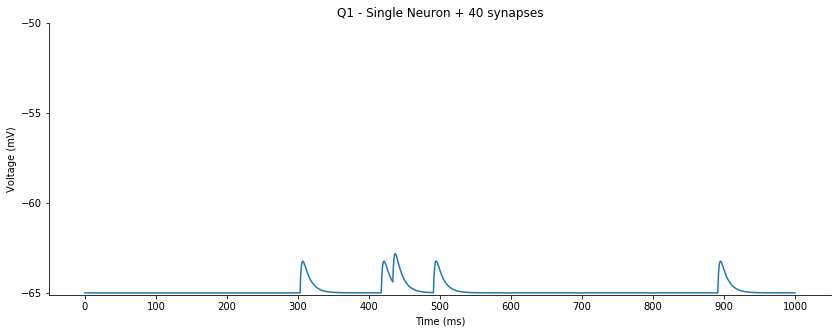

In [70]:
def plot_q1(title, filename, time, volts):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.plot(time, volts)
    ax.set_yticks(range(-65,-45,5))
    ax.set_xticks(range(0,1001,100))
    fig.savefig(f"plots/{filename}.png", bbox_inches='tight', pad_inches=0.2, dpi=100)
title = "Q1 - Single Neuron + 40 synapses"
plot_q1(title, 'b_q1', time, volts)

In [7]:
#volts[800:1200]